# Imports & Preprocessing

In [1]:
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import explained_variance_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# hide warnings
import warnings
from joblib import dump, load

warnings.filterwarnings('ignore')

In [2]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [39]:
import contractions
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words

def preprocess(data_real, colum_name):
    def remove_punctuation(sentence):
        unnecessary_dict = {}
        for symb in string.punctuation:
            unnecessary_dict[symb] = ' '
        unnecessary_dict['\x96'] = ' '
        unnecessary_dict['\x85'] = ' '
        unnecessary_dict['´'] = ' '
        unnecessary_dict['\x97'] = ' '
        unnecessary_dict['…'] = ' '
        unnecessary_dict['’'] = ' '
        unnecessary_dict['\x91'] = ' '

        s = sentence.replace('<br />', '')
        s = s.translate(s.maketrans(unnecessary_dict))
        return s

    def remove_stopwords(sentence):
        without_sw = []
        stop_words = stopwords.words('english')
        
        words = sentence.split()
        for word in words:
            if word not in stop_words:
                without_sw.append(word)

        res = ' '.join(without_sw)
        return res

    def lemmatize_text(text):
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in text.split()]
        return " ".join(words)
    
    def takeCharsUntilNotRoman(w):
        result = []
        for c in w:
            if ord(c) <128 or (ord(c) >= 65313 and ord(c) <= 65339) or (ord(c) >= 65345 and ord(c) <= 65371):
                result.append(c)
            else:
                break
        # Assume a word needs to be at least 2 chars long
        if len(result) > 1:
            return ''.join(result)
        return ''

    def removeNonEnglishWordsFunct(x):
        words = set(nltk.corpus.words.words())
        filteredSentence = (takeCharsUntilNotRoman(w) for w in nltk.wordpunct_tokenize(x) \
                                    if w.lower() in words or not w.isalpha() or w[0].upper())
    
        return ' '.join([a for a in filteredSentence if a])
    
    data = data_real.copy()
    #all to lowercase
    data[colum_name] = data[colum_name].str.lower()
    #change contractions (i've, don't ...) to full forms (i have, do not)
    data[colum_name] = data[colum_name].apply(lambda x: " ".join([contractions.fix(word) for word in str(x).split()]))
    #remove non-english
    #data[colum_name] = data[colum_name].apply(removeNonEnglishWordsFunct)
    #remove punctuation
    data[colum_name] = data[colum_name].apply(remove_punctuation)
    #remove numbers
    data[colum_name] = data[colum_name].apply(lambda s: re.sub('\d+', ' ', s))
    #remove stopwords
    data[colum_name] = data[colum_name].apply(remove_stopwords)
    #remove single letters
    data[colum_name] = data[colum_name].apply(lambda s: re.sub('\b[a-zA-Z]\b', ' ', s))
    #remove excess spaces
    data[colum_name] = data[colum_name].apply(lambda s: re.sub(' +', ' ', s))
    #lemmatize
    data[colum_name] = data[colum_name].apply(lemmatize_text)
    #tokenize
    data[f'tokenized_{colum_name}'] = data[colum_name].apply(lambda s: s.split())
    #add number of words column
    data[f'word_num_{colum_name}'] = data[f'tokenized_{colum_name}'].str.len()
    
    return data

In [4]:
train_full = pd.read_csv('train.csv')
test_full = pd.read_csv('test.csv')

train_full = train_full.set_index('id')
test_full = test_full.set_index('id')

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


del_columns = ['book_title', 'book_desc', 'book_genre', 'book_authors', 'book_format']

class CleaningTextData(BaseEstimator, TransformerMixin):
    def __init__(self, del_columns=del_columns):
        self.del_columns = del_columns 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        data_new = X.copy()
        
        # cleaning 
        data_new = preprocess(data_new, 'book_desc')
        data_new['book_genre_list'] = data_new['book_genre'].apply(lambda x: list(set((" ".join(str(x).split('|'))).split())) if x is not None else ['ok'])
        data_new['book_authors_list'] = data_new['book_authors'].apply(lambda x: list(set((" ".join(str(x).split('|'))).split())) if x is not None else ['ok'])
        data_new.book_format = data_new.book_format.fillna(data_new.book_format.mode())
        data_new = preprocess(data_new, 'book_format')
        data_new.book_pages = data_new['book_pages'].apply(lambda x: int(x.split()[0]) if len(str(x).split()) > 1 else np.nan)
        data_new = preprocess(data_new, 'book_title')
        data_new = data_new.drop(self.del_columns, axis=1)
        
        # to string some columns
        self.columns_str = ['tokenized_book_desc', 'book_genre_list', 'book_authors_list', 'tokenized_book_format', 'tokenized_book_title']
        
        for name in self.columns_str:
            data_new[name] = data_new[name].apply(lambda x: np.nan if len(x)==0 or x[0] == 'ok' else ' '.join(x))
            
        # come back to nan
        columns_back = ['book_image_url',
                         'tokenized_book_desc',
                         'word_num_book_desc',
                         'book_genre_list',
                         'book_authors_list',
                         'tokenized_book_format',
                         'tokenized_book_title']
        
        for name in columns_back:
            data_new[name] = data_new[name].apply(lambda x: np.nan if x == 'nan' else x)
            
        return data_new
    
class FillingNaN(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
#         self.columns_input = columns_input
        
    def fit(self, X, y=None):
        print('fit filling na')

        data = X.copy()
        
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(data)
        
        return self
    
    def transform(self, X):
        data = X.copy()
        data_subset_transformed = self.imputer.transform(data)
        data = pd.DataFrame(data_subset_transformed, columns=data.columns)
        
        return data

columns_idf = ['tokenized_book_desc', 'book_genre_list', 'book_authors_list', 'tokenized_book_format', 'tokenized_book_title']

class TfIdf(BaseEstimator, TransformerMixin):
    def __init__(self, columns_idf=columns_idf, max_features=10000):
        self.columns_idf = columns_idf
        self.max_features = max_features
        self.model_dic = {}

    def fit(self, X, y=None):
        print('fit tfidf')
        data = X.copy()
        
        for name in self.columns_idf:
            self.model_dic[name] = TfidfVectorizer(stop_words='english', max_features=self.max_features)
            self.model_dic[name].fit(data[name].values)
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        data_new = data.copy()
        
        for name, model in self.model_dic.items():
            print
            data_transformed = model.transform(data[name].values).toarray()
            data_transformed = pd.DataFrame(data_transformed, columns=[f'{name}_{x}' for x in range(data_transformed.shape[1])])
            data_new = pd.concat([data_new, data_transformed], axis=1)
        
        data_new = data_new.drop(list(self.model_dic.keys()) + ['book_image_url'], axis=1)
        
        return data_new

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_full.drop(['book_rating'], axis=1), train_full.book_rating, test_size=0.1, random_state=13)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (36000, 9)
X_test shape: (4000, 9)


In [7]:
name = 'dft_idf_200.joblib'
cleaning_pipe_line = load(name)

In [8]:
train_pipeline = cleaning_pipe_line.transform(X_train)
test_pipeline = cleaning_pipe_line.transform(X_test)
submit_pipe = cleaning_pipe_line.transform(test_full)

In [9]:
train_pipeline.head()

,book_pages,book_review_count,book_rating_count,word_num_book_desc,word_num_book_format,word_num_book_title,tokenized_book_desc_0,tokenized_book_desc_1,tokenized_book_desc_2,tokenized_book_desc_3,...,tokenized_book_title_190,tokenized_book_title_191,tokenized_book_title_192,tokenized_book_title_193,tokenized_book_title_194,tokenized_book_title_195,tokenized_book_title_196,tokenized_book_title_197,tokenized_book_title_198,tokenized_book_title_199
0,320,624,3906,109,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,356,122,700,72,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,434,907,6709,114,1,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,358,160,4892,42,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,244,2,3,76,1,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plots

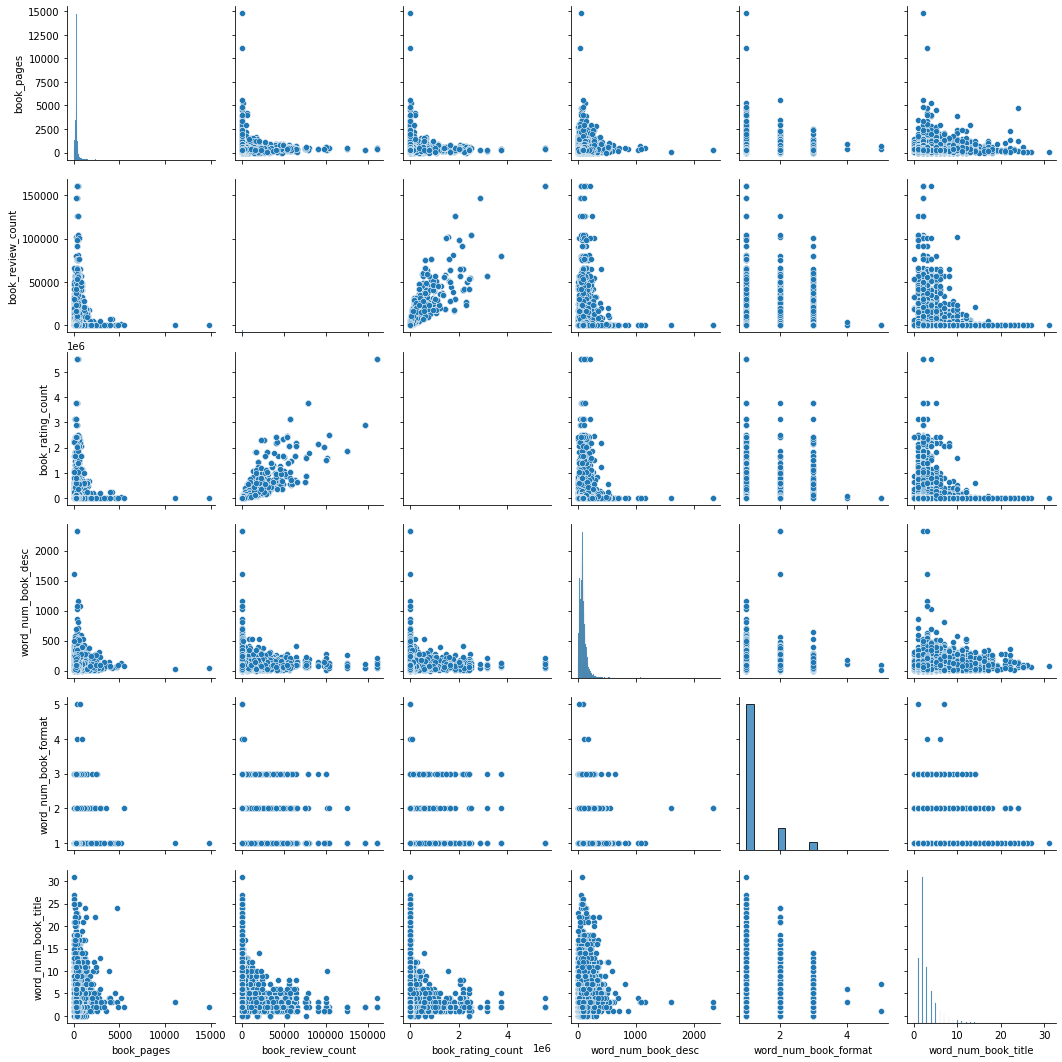

In [57]:
#зачем
sns.pairplot(train_pipeline[['book_pages', 'book_review_count', 'book_rating_count', 'word_num_book_desc', 'word_num_book_format', 'word_num_book_title']])

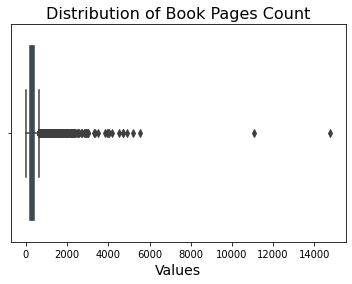

In [10]:
boxplot = sns.boxplot(x=train_pipeline['book_pages'])

boxplot.axes.set_title("Distribution of Book Pages Count", fontsize=16)
boxplot.set_xlabel("Values", fontsize=14)
plt.show()

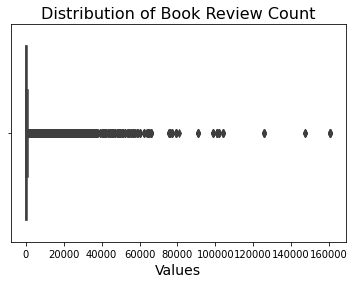

In [11]:
boxplot = sns.boxplot(x=train_pipeline['book_review_count'])

boxplot.axes.set_title("Distribution of Book Review Count", fontsize=16)
boxplot.set_xlabel("Values", fontsize=14)
plt.show()

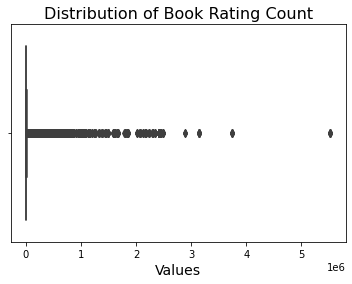

In [12]:
boxplot = sns.boxplot(x=train_pipeline['book_rating_count'])

boxplot.axes.set_title("Distribution of Book Rating Count", fontsize=16)
boxplot.set_xlabel("Values", fontsize=14)
plt.show()

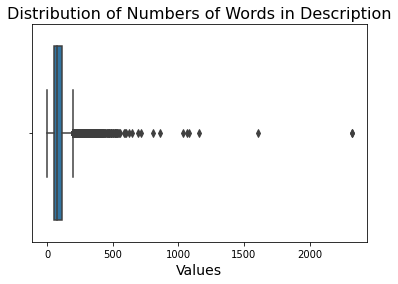

In [13]:
boxplot = sns.boxplot(x=train_pipeline['word_num_book_desc'])

boxplot.axes.set_title("Distribution of Numbers of Words in Description", fontsize=16)
boxplot.set_xlabel("Values", fontsize=14)
plt.show()

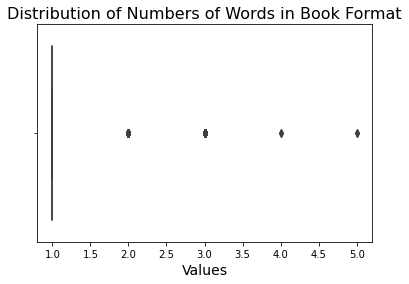

In [14]:
boxplot = sns.boxplot(x=train_pipeline['word_num_book_format'])

boxplot.axes.set_title("Distribution of Numbers of Words in Book Format", fontsize=16)
boxplot.set_xlabel("Values", fontsize=14)
plt.show()

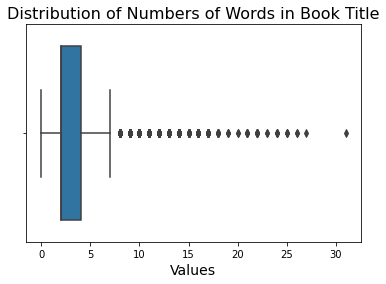

In [15]:
boxplot = sns.boxplot(x=train_pipeline['word_num_book_title'])

boxplot.axes.set_title("Distribution of Numbers of Words in Book Title", fontsize=16)
boxplot.set_xlabel("Values", fontsize=14)
plt.show()

In [40]:
train_full_preprocessed = preprocess(train_full, 'book_desc')

In [69]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(token_pattern='(?u)[a-zA-Z][a-z_]+').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(train_full_preprocessed['book_desc'], 20)
df1 = pd.DataFrame(common_words, columns = ['DescText' , 'count'])
df1.groupby('DescText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in description after preprocessing')

In [76]:
common_words = get_top_n_words(train_full['book_desc'], 20)
df2 = pd.DataFrame(common_words, columns = ['DescText' , 'count'])
df2.groupby('DescText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in description before preprocessing')

In [77]:
book_authors = train_full['book_authors']
book_authors = book_authors.apply(lambda x: x.split('|'))
book_authors = [item.replace(' ', '_') for sublist in book_authors for item in sublist]


common_authors = get_top_n_words(book_authors, 20)
df3 = pd.DataFrame(common_authors, columns = ['DescText' , 'count'])
df3.groupby('DescText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 authors')

In [72]:
book_genres = train_full['book_genre'].fillna("")
book_genres = book_genres.apply(lambda x: " ".join(list(set((" ".join(str(x).split('|'))).split()))))

common_genres = get_top_n_words(book_genres, 20)
df4 = pd.DataFrame(common_genres, columns = ['Genre' , 'count'])
df4.groupby('Genre').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 genres')

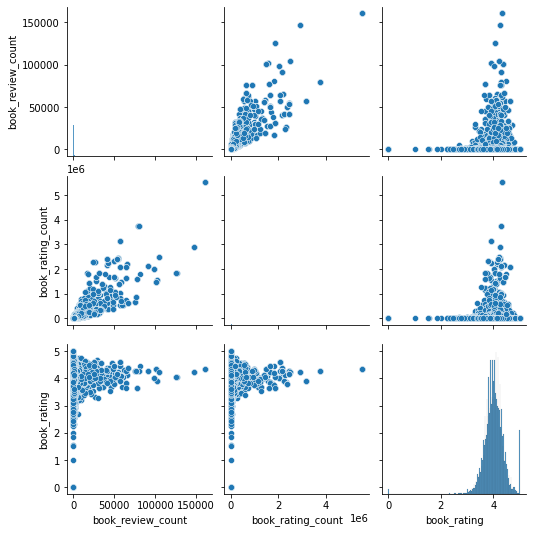

In [50]:
sns.pairplot(train_full)

In [56]:
train_full['book_rating'].iplot(
    kind='hist',
    bins=50,
    xTitle='book_review_count',
    linecolor='black',
    yTitle='count',
    title='Book Rating Distribution')